# Module

In [1]:
import gc
import optuna
import janestreet
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dataset

In [2]:
%%time

data = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')

print(data.shape)
data.head()

(2390491, 138)
CPU times: user 1min 29s, sys: 6.63 s, total: 1min 36s
Wall time: 2min 31s


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


# Preprocess

In [3]:
data = data.drop(['feature_113','feature_89','feature_101'], axis=1)

train = data[data['weight'] != 0]
train = train.fillna(train.mean())

print(train.isnull().sum()[1:7])

weight    0
resp_1    0
resp_2    0
resp_3    0
resp_4    0
resp      0
dtype: int64


In [4]:
del(data)
gc.collect()

20

In [5]:
# train['action'] = ((train['weight'].values * train['resp'].values) > 0).astype('int')
# train['action'] = (train['resp'] > 0) * 1
train['action'] = ((train['resp'].values) > 0).astype(int)

train['action'].head()

1    0
4    0
6    1
7    1
8    0
Name: action, dtype: int64

In [6]:
features = train.columns[train.columns.str.contains('feature')]
target = 'action'

feature = features.drop('feature_0')

print(len(features))
print(features[:2], '...', features[128:])

127
Index(['feature_0', 'feature_1'], dtype='object') ... Index([], dtype='object')


In [7]:
train['resp_0'] = (((train['resp'].values)*train['weight']) > 0).astype(int)
train['resp_1'] = (((train['resp_1'].values)*train['weight']) > 0).astype(int)
train['resp_2'] = (((train['resp_2'].values)*train['weight']) > 0).astype(int)
train['resp_3'] = (((train['resp_3'].values)*train['weight']) > 0).astype(int)
train['resp_4'] = (((train['resp_4'].values)*train['weight']) > 0).astype(int)

In [8]:
f_mean = np.mean(train[features[1:]].values, axis=0)

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']

In [9]:
X_train = train[features].values
y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

print(X_train.shape)
print(y_train.shape)
y_train[:5]

(1981287, 127)
(1981287, 5)


array([[0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0]])

# Modeling

In [10]:
for i in range(y_train.shape[1]):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train[:,i], random_state=666, test_size=0.2, stratify=y_train[:,i])

print(X_tr.shape)
print(y_tr.shape)
print(X_val.shape)
print(y_val.shape)

(1585029, 127)
(1585029,)
(396258, 127)
(396258,)


In [11]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    tree_method = 'gpu_hist'
    missing = -999
    random_state = 666
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        tree_method='gpu_hist',
        missing=-999,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_proba)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

'\ndef create_model(trial):\n    num_leaves = trial.suggest_int("num_leaves", 2, 31)\n    n_estimators = trial.suggest_int("n_estimators", 50, 300)\n    learning_rate = trial.suggest_uniform(\'learning_rate\', 0.0001, 0.99)\n    max_depth = trial.suggest_int(\'max_depth\', 3, 8)\n    min_child_samples = trial.suggest_int(\'min_child_samples\', 100, 1200)\n    min_data_in_leaf = trial.suggest_int(\'min_data_in_leaf\', 5, 90)\n    bagging_freq = trial.suggest_int(\'bagging_freq\', 1, 7)\n    bagging_fraction = trial.suggest_uniform(\'bagging_fraction\', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform(\'feature_fraction\', 0.0001, 1.0)\n    subsample = trial.suggest_uniform(\'subsample\', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform(\'colsample_bytree\', 0.1, 1.0)\n    tree_method = \'gpu_hist\'\n    missing = -999\n    random_state = 666\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate=

In [12]:
params = {'num_leaves': 29,
          'n_estimators': 278,
          'learning_rate': 0.5057097928147115,
          'max_depth': 8,
          'min_child_samples': 925,
          'min_data_in_leaf': 12,
          'bagging_freq': 1,
          'bagging_fraction': 0.9358368171887463,
          'feature_fraction': 0.9082822621738548,
          'subsample': 0.3271583480250675,
          'colsample_bytree': 0.5473805329928911,
          'tree_method': 'gpu_hist',
          'random_state': 666}

In [13]:
%%time

cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train[:, 1])

y_proba = cls.predict_proba(X_val)[:,1]

print('AUC: ', roc_auc_score(y_val, y_proba))

AUC:  0.5706919208546931
CPU times: user 9min 5s, sys: 1.7 s, total: 9min 7s
Wall time: 2min 23s


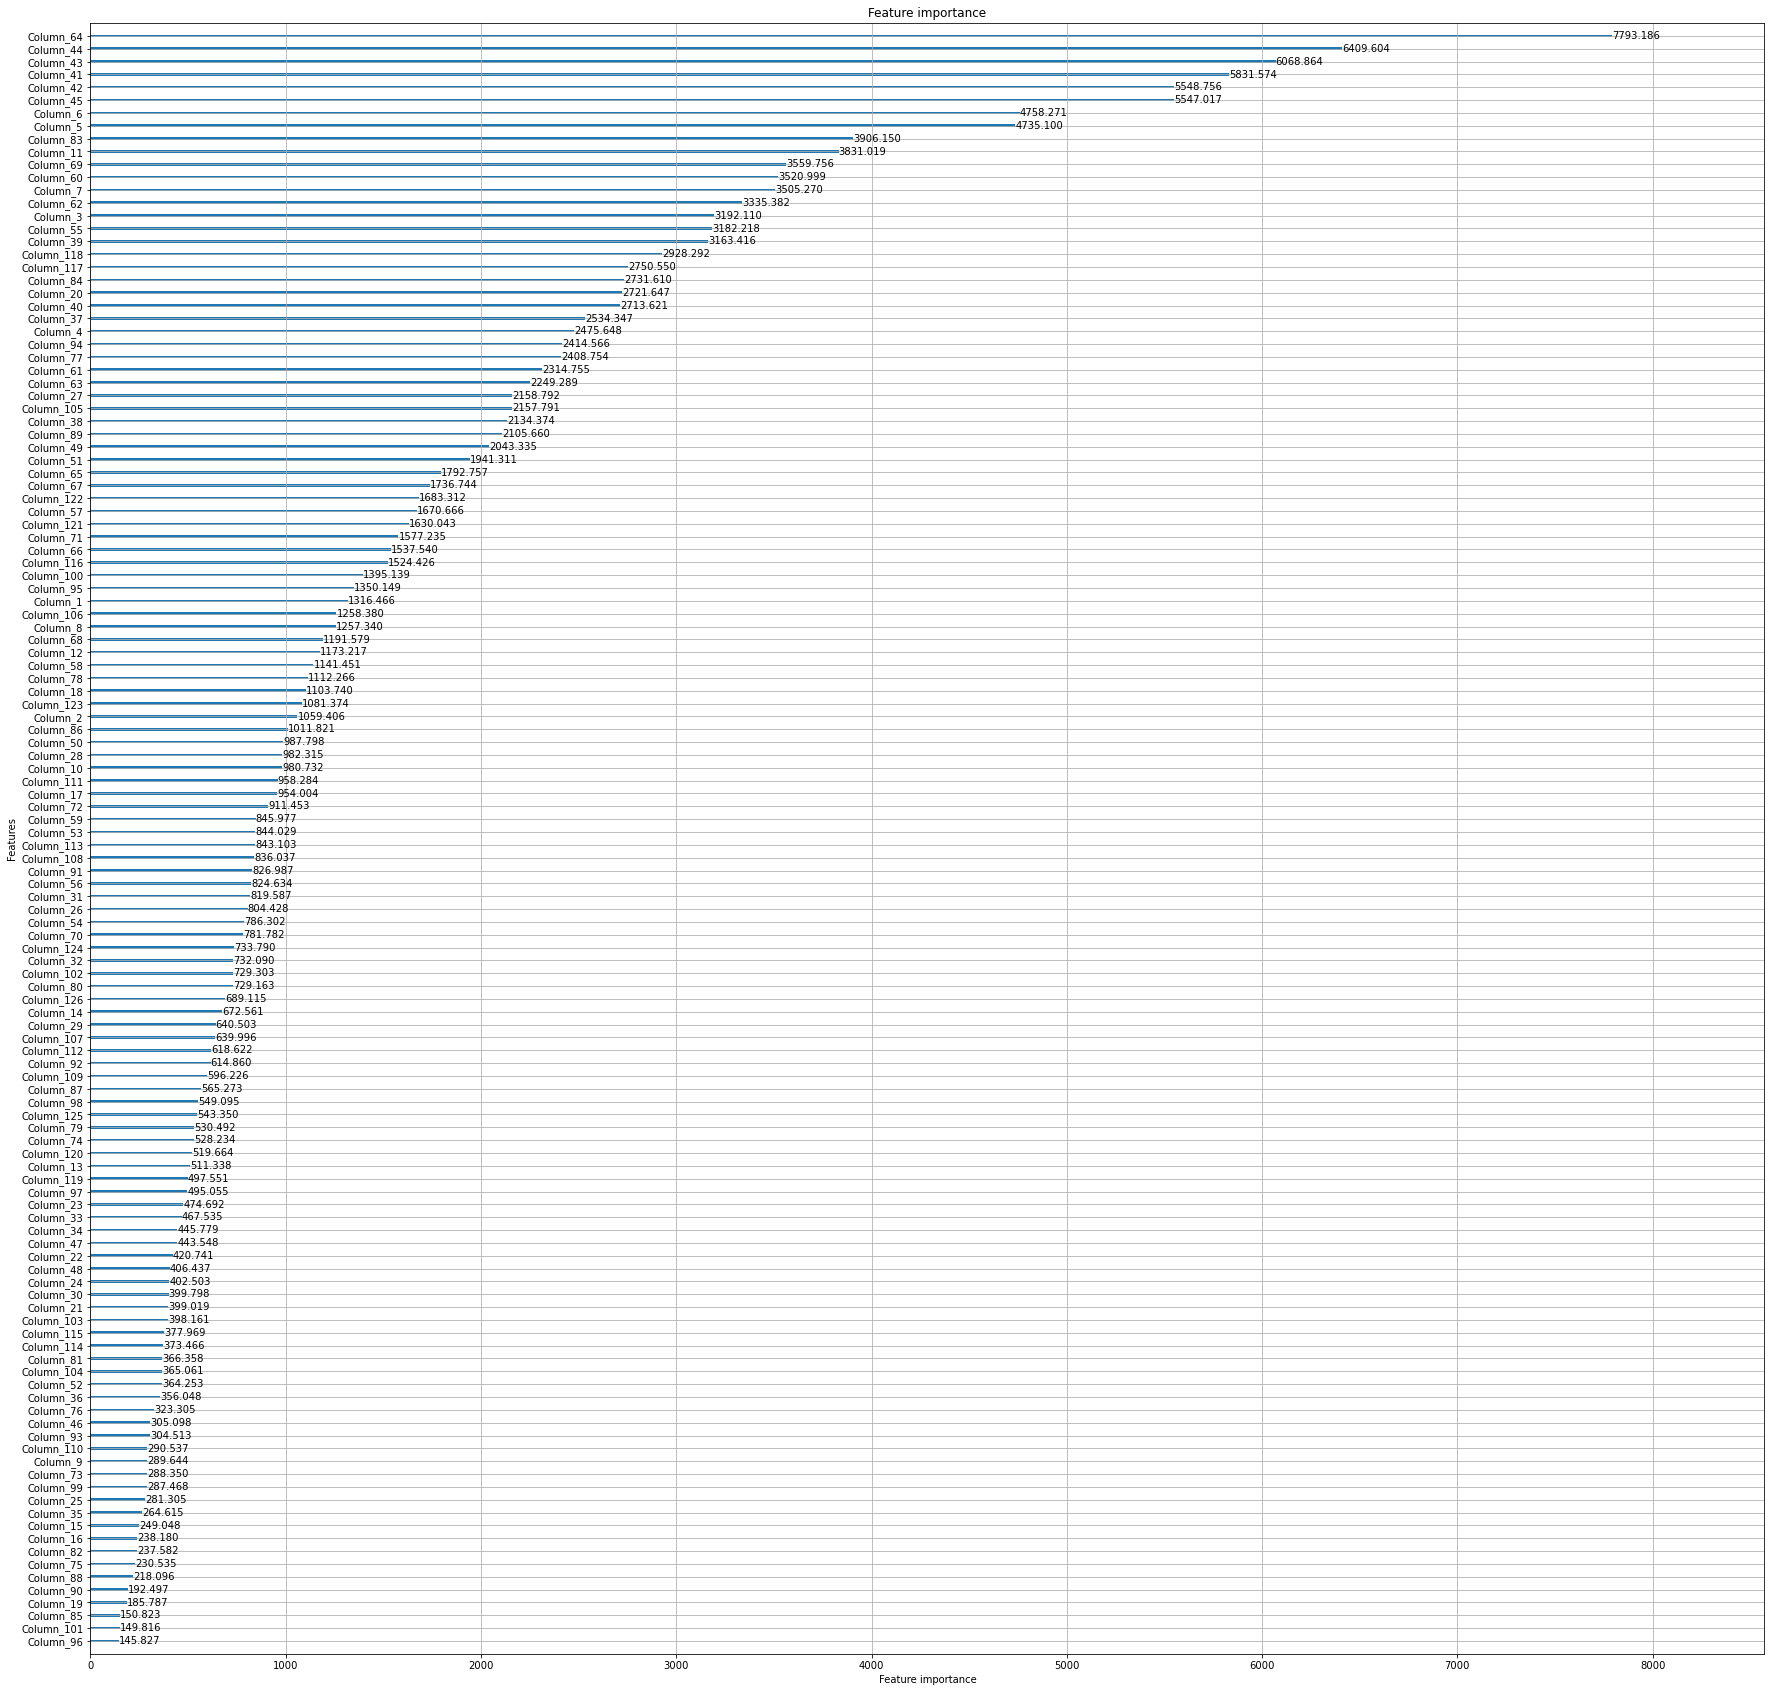

In [14]:
fig,ax = plt.subplots(figsize=(30,30))
lgb.plot_importance(cls, ax=ax,importance_type='gain',max_num_features=130)
plt.show()

In [15]:
del(train)
gc.collect()

25

# Submit

In [16]:
env = janestreet.make_env()
iter_test = env.iter_test()

In [17]:
'''
%%time

for (test, sample_prediction) in iter_test:
    test = test.fillna(0.5)
    sample_prediction['action'] = cls.predict(test[features])
    env.predict(sample_prediction)
    
'''

"\n%%time\n\nfor (test, sample_prediction) in iter_test:\n    test = test.fillna(0.5)\n    sample_prediction['action'] = cls.predict(test[features])\n    env.predict(sample_prediction)\n    \n"

In [18]:
%%time

for (test, sample_prediction) in iter_test:
    test = test.fillna(0.5)
    
    if test['weight'].item() > 0:
        sample_prediction['action'] = cls.predict(test[features])
    else:
        sample_prediction['action'] = 0
    
    env.predict(sample_prediction)

CPU times: user 17min 10s, sys: 30.7 s, total: 17min 41s
Wall time: 4min 33s
